Instrucciones Generales• 
Fecha límite: 2 de octubre, 11:59 PM.
Debes crear un repositorio
Crea 2 carpetas: código y resultados
Sube un video explicando el código y los resultados. 
Utiliza YouTube y haz que el enlace sea público.
Google Sheet:https://docs.google.com/spreadsheets/d/10vy5pyNvLUAb2pCJLye7gaOPHOIhjdmzUTKdiUbF5oI/edit?usp=sharing🏥 
Tarea: Análisis Geoespacial de Hospitales en Perú

1) Configuración del Repositorio
Cree un nuevo repositorio público en GitHub llamado Hospitals-Access-Peru.
Utilice el repositorio Rodrigo John Paradox como plantilla.

2) Análisis geoespacial con GeoPandas
Conjuntos de Datos y Enlaces Oficiales
1. Hospitales (MINSA – IPRESS)👉 MINSA – Registro Nacional de IPRESS
 - Utilice solo el subconjunto operativo: filtre los registros para hospitales que estén en funcionamiento (“estado de funcionamiento”).
 - Aclaración: “Estado de funcionamiento” se refiere a la base de datos oficial del MINSA de hospitales operativos/activos, según el conjunto de datos y el diccionario de datos.
 - Mantenga solo los registros con coordenadas válidas (latitud y longitud).

2. Centros Poblados (INEI)👉 Conjunto de Datos – Centros Poblados
3. Límites Administrativos (Distritos de Perú)Use el archivo shapefile de distritos empleado en esta referencia:👉 Curso: GeoPandas – Distritos de PerúCRS recomendado: EPSG:4326.

Columnas clave (hospitales):INSTITUCIÓN, NOMBRE DEL ESTABLECIMIENTO, CLASIFICACION, DEPARTAMENTO, PROVINCIA, DISTRITO, ESTADO, LATITUD (NORTE), LONGITUD (ESTE)

In [1]:
import pandas as pd

In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt 
import chardet

In [5]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium 
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

In [4]:
!pip install folium

  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.1-py3-none-any.whl (26 kB)


Cuando abres un archivo en Python con open(), puedes hacerlo en distintos modos:
- "r" → lectura en texto (por defecto).
- "w" → escritura en texto (crea o sobrescribe).
- "rb" → lectura en binario.
    - El archivo se lee tal cual, en forma de bytes (b'...'), sin intentar convertirlos a texto.
    - Eso evita que Python intente adivinar la codificación desde el inicio.
- "wb" → escritura en binario.

Ese código sirve para detectar la codificación de un archivo CSV usando la librería
base = open(r'IPRESS.csv', 'rb').read()
det = chardet.detect(base)     # analiza los bytes
charenc = det['encoding']      # obtiene la codificación detectada
charenc

¿Qué es UTF-8 e ISO-8859-1?
- UTF-8  Es la codificación más usada hoy en día (estándar en la web, Python, Linux, bases de datos modernas).

- ISO-8859-1 / Latin-1: Es una codificación más antigua y simple (1 byte por carácter, máximo 256 símbolos).
         - Muy usada en Windows y Excel en español/portugués antes de que UTF-8 se popularizara.
- 'MacRoman' : Es una codificación de caracteres usada en computadoras Apple antiguas (Macintosh) antes de que    
               Unicode/UTF-8 se volviera estándar. 
          Igual que ISO-8859-1, usa 1 byte por carácter (256 símbolos como máximo). Incluye letras con acentos, signos de puntuación y algunos símbolos específicos que usaban las Mac. Hoy en día casi no se usa, pero aún aparecen archivos CSV o TXT creados en Excel para Mac o software antiguo.

# DATA

In [6]:
base = open(r'IPRESS.csv', 'rb').read()
det = chardet.detect(base)
charenc = det['encoding']
charenc

In [4]:
import pandas as pd

def detectar_codificacion(archivo, codificaciones=None):
    if codificaciones is None:
        codificaciones = ["utf-8", "latin1", "ISO-8859-1", "windows-1252", "MacRoman"]

    mejor_encoding = None
    mejor_score = -1
    df_correcto = None

    for enc in codificaciones:
        try:
            # Leer unas pocas filas de prueba
            df = pd.read_csv(archivo, encoding=enc, nrows=20)

            # Calcular "score" = cuántos caracteres raros aparecen
            texto = df.to_string()
            # cuenta símbolos sospechosos (mojibake)
            raros = texto.count("�") + texto.count("Ã") + texto.count("Û")
            score = -raros  # menos raro = mejor

            print(f"Probando {enc} -> caracteres raros encontrados: {raros}")

            if score > mejor_score:
                mejor_score = score
                mejor_encoding = enc
                df_correcto = df

        except Exception as e:
            print(f"Error con {enc}: {e}")

    return mejor_encoding, df_correcto


# Uso
archivo = "IPRESS.csv"
encoding_detectado, df = detectar_codificacion(archivo)

print("\n✅ Codificación elegida:", encoding_detectado)
print(df.head())


Error con utf-8: 'utf-8' codec can't decode byte 0xf3 in position 9: invalid continuation byte
Probando latin1 -> caracteres raros encontrados: 0
Probando ISO-8859-1 -> caracteres raros encontrados: 0
Probando windows-1252 -> caracteres raros encontrados: 0
Probando MacRoman -> caracteres raros encontrados: 14

✅ Codificación elegida: latin1
         Institución  Código Único Nombre del establecimiento  \
0            PRIVADO         16618                 SONRIE MAS   
1  GOBIERNO REGIONAL          7050                     AMBATO   
2  GOBIERNO REGIONAL            99  SANTA ISABEL DE YUMBATURO   
3            PRIVADO         19555               DENTOCAPLINA   
4               OTRO         18792  MEDICO DE FAMILIA MANTARA   

                                       Clasificación  \
0  CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...   
1                 PUESTOS DE SALUD O POSTAS DE SALUD   
2                 PUESTOS DE SALUD O POSTAS DE SALUD   
3  CONSULTORIOS MEDICOS Y DE OTROS PROFES

* pd.read_csv(...) → lee tu archivo IPRESS.csv.

* encoding=charenc → le dices a pandas que use la codificación detectada con chardet (en tu caso MacRoman).

* data.head(5) → muestra las primeras 5 filas del DataFrame.

In [7]:
data = pd.read_csv( r'IPRESS.csv', encoding = 'latin1')
data.head(3)
# Mi data tiene 20819 rows × 33 columns

,Institución,Código Único,Nombre del establecimiento,Clasificación,Tipo,Departamento,Provincia,Distrito,UBIGEO,Dirección,...,Inicio de Actividad,Director Médico y/o Responsable de la Atención de Salud,Estado,Situación,Condición,Inspección,NORTE,ESTE,COTA,CAMAS
0,PRIVADO,16618,SONRIE MAS,CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,LIMA,LIMA,SANTIAGO DE SURCO,150140,"AV. CAMINOS DEL INCA 2028 OF.201, URBANIZACION...",...,11/03/2013,GILBERTO MARTIN AQUIJE GAVILAN,ACTIVADO,,EN FUNCIONAMIENTO,,NaN,NaN,NaN,NaN
1,GOBIERNO REGIONAL,7050,AMBATO,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,CAJAMARCA,CUTERVO,SANTA CRUZ,60611,COMUNIDAD DE AMBATO,...,29/06/2006,IDELSO MENOR CHAVEZ,ACTIVADO,,EN FUNCIONAMIENTO,,-78.858380,-6.133523,1724.0,NaN
2,GOBIERNO REGIONAL,99,SANTA ISABEL DE YUMBATURO,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,LORETO,LORETO,PARINARI,160302,ACTUALIZAR,...,01/01/1900,JULIO TONY CAITIMARI MACHOA,ACTIVADO,,EN FUNCIONAMIENTO,,-74.258139,-4.581509,124.0,NaN


In [8]:
data.shape

(20819, 33)

In [9]:
data.dtypes

Institución                                                 object
Código Único                                                 int64
Nombre del establecimiento                                  object
Clasificación                                               object
Tipo                                                        object
Departamento                                                object
Provincia                                                   object
Distrito                                                    object
UBIGEO                                                       int64
Dirección                                                   object
Código DISA                                                  int64
Código Red                                                   int64
Código Microrred                                             int64
DISA                                                        object
Red                                                         ob

1. Hospitales (MINSA – IPRESS)👉 MINSA – Registro Nacional de IPRESS
 - Utilice solo el subconjunto operativo: filtre los registros para hospitales que estén en funcionamiento (“estado de funcionam ento”). <- Condición
 - Aclaración: “Estado de funcionamiento” se refiere a la base de datos oficial del MINSA de hospitales operativos/activos, según el conjunto de datos y el diccionario de datos.
 - Mantenga solo los registros con coordenadas válidas (latitud y longitud).

In [10]:
data = data[data["Condición"] == "EN FUNCIONAMIENTO"]
# Esto significa que son 19 observciones menos que no contienen la condición de un hospital "EN FUNCIONAMIENTO"


In [11]:
# Debemos considerar las observaciones con la Latitud(NORTE) y Longitud(ESTE) CORRECTO= sin NaN
data[['NORTE', 'ESTE']].isna().sum()
#Son  12858 que serán retiradas por presentar NaN

NORTE    12858
ESTE     12858
dtype: int64

In [12]:
# Como existen 12858 observaciones que no deberían ser consideradas porque no tienen información sobre NORTE y ESTE, se eliminan
data = data.dropna(subset=['NORTE', 'ESTE'])

# dropna(...) → elimina las filas con valores nulos.
# subset=['NORTE', 'ESTE'] → indica que solo debe revisar esas dos columnas.
# data1 = ... → reasignamos a la variable para guardar el dataframe limpio.


In [13]:
data[['NORTE', 'ESTE']].isna().sum()

NORTE    0
ESTE     0
dtype: int64

In [14]:
data.shape

(7942, 33)

In [15]:
import pandas as pd

In [16]:
data['UBIGEO'] = data['UBIGEO'].astype(str).astype(int)

In [17]:
columnas_clave = [
    'UBIGEO',
    'Institución',
    'Nombre del establecimiento',
    'Clasificación',
    'Departamento',
    'Provincia',
    'Distrito',
    'Estado',
    'NORTE',
    'ESTE'
]

data= data[columnas_clave]

In [18]:
data.shape

(7942, 10)

## Shape File
- Nuestra data del mapa tiene 1873 rows × 11 columns
- La Data1 tiene rows 7942 × 33 columns

In [19]:
maps = gpd.read_file(r'shape_file/DISTRITOS.shp')

In [20]:
maps

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...,...,...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,CASTILLO GRANDE,0001,1,INEI,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,PUEBLO NUEVO,0001,1,INEI,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,PACAE,0001,1,INEI,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,SAN MIGUEL,0001,1,INEI,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [21]:
# Select only relevant columns
maps = maps[['IDDIST', 'geometry']]
maps = maps.rename({'IDDIST':'UBIGEO'}, axis =1 )
maps

,UBIGEO,geometry
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...
1868,100608,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,100609,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,100610,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,211105,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [22]:
maps.dtypes

UBIGEO        object
geometry    geometry
dtype: object

In [23]:
# Object or srting to int

maps['UBIGEO'] = maps['UBIGEO'].astype(str).astype(int)
maps



,UBIGEO,geometry
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...
1868,100608,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,100609,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,100610,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,211105,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [24]:
maps.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

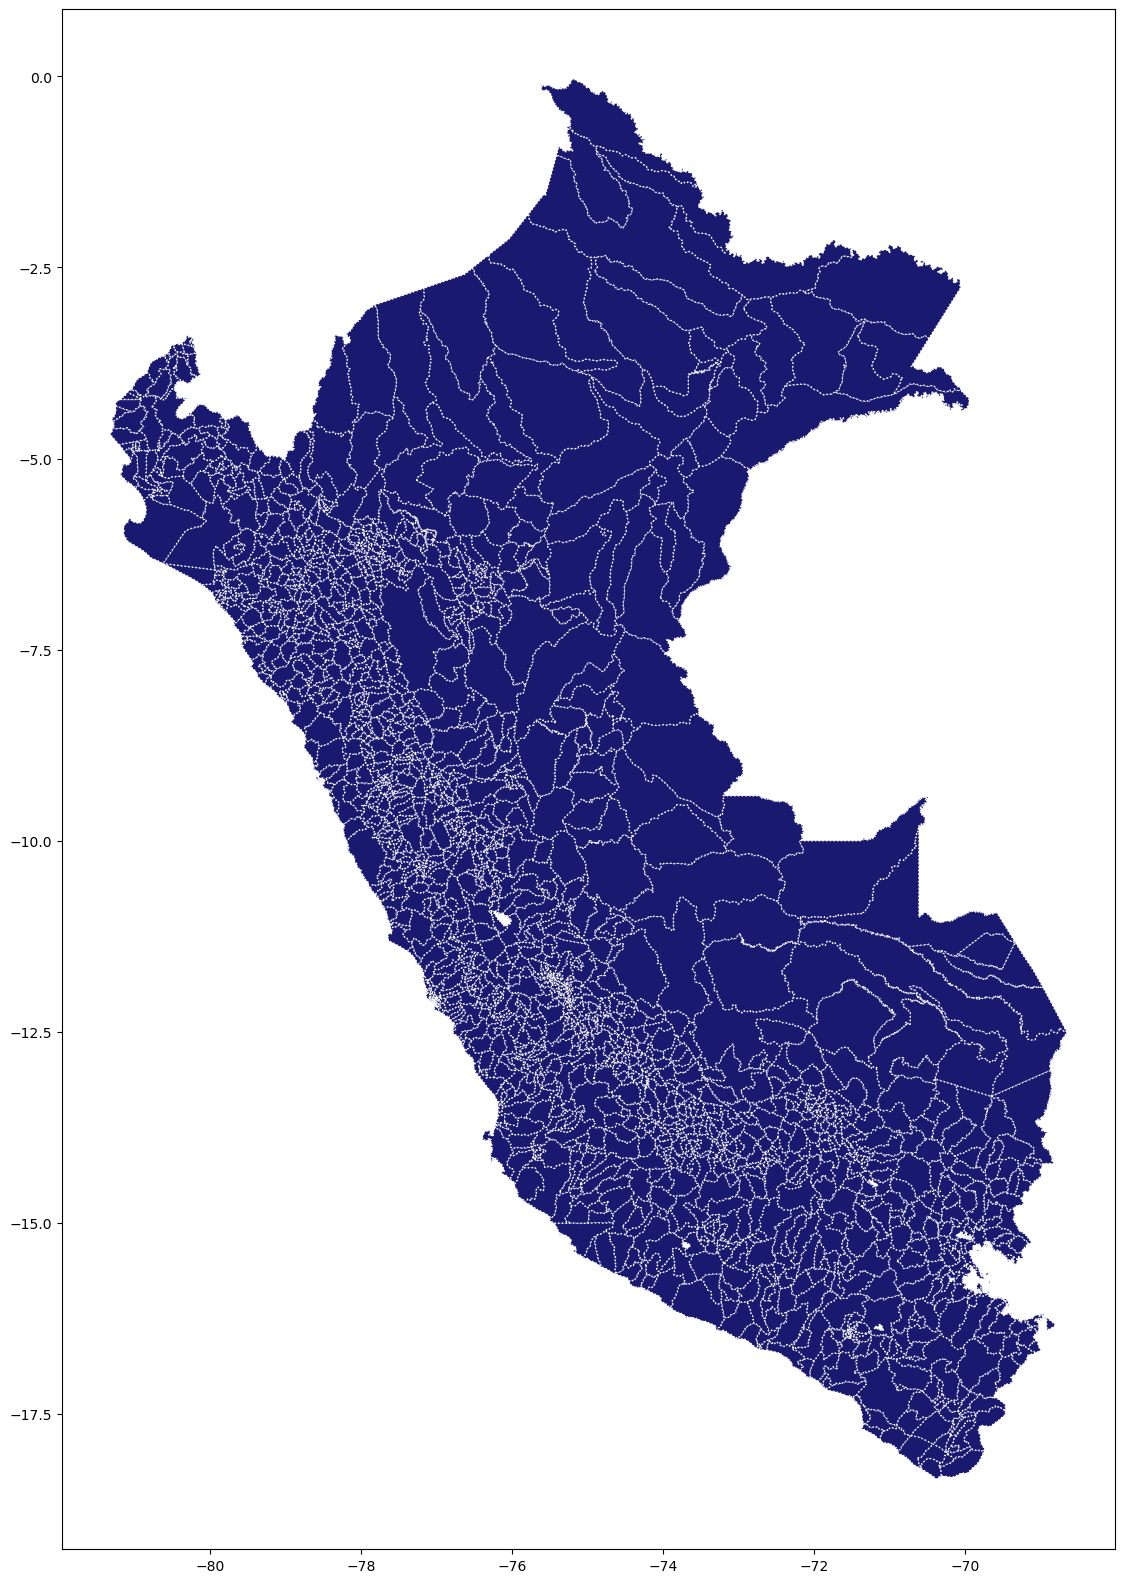

In [25]:
# Plot using geopandas

#figure and axis
fig, ax = plt.subplots(figsize=(20, 20))

maps.plot(  ax=ax, color='midnightblue', linestyle='dotted',
            edgecolor='white' )
plt.show()


# MERGE -  Hospital Data & Shapefile

In [26]:
maps.head(3)

,UBIGEO,geometry
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."


In [27]:
maps.shape

(1873, 2)

In [28]:
dataset = pd.merge(maps, data, how="left", on="UBIGEO")
dataset


,UBIGEO,geometry,Institución,Nombre del establecimiento,Clasificación,Departamento,Provincia,Distrito,Estado,NORTE,ESTE
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CODO DEL POZUZO,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.463665,-9.669402
1,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,HUAMPOMAYO,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.591200,-9.969250
2,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CHORROPAMPA,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.394620,-9.850610
3,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",GOBIERNO REGIONAL,PRINCIPE DE PAZ,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,TOURNAVISTA,ACTIVADO,-74.683542,-8.995790
4,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",GOBIERNO REGIONAL,TOURNAVISTA,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,TOURNAVISTA,ACTIVADO,-74.702805,-8.934338
...,...,...,...,...,...,...,...,...,...,...,...
7950,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,PEÑICO,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.437500,-10.931177
7951,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",ESSALUD,CENTRO DE ATENCION PRIMARIA I HUMAYA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.409616,-11.098534
7952,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,VILCAHUAURA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.474190,-11.072751
7953,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,HUMAYA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.409943,-11.099675


In [29]:
data.shape    #(7942, 10)
maps.shape    #(1873, 2)

dataset.shape    #7894 rows × 11 columns (merge) -> INICIAL
                   # 7955 rows × 11 columns  -> FINAL

(7955, 11)

In [30]:
dataset.head(3)

,UBIGEO,geometry,Institución,Nombre del establecimiento,Clasificación,Departamento,Provincia,Distrito,Estado,NORTE,ESTE
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CODO DEL POZUZO,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.463665,-9.669402
1,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,HUAMPOMAYO,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.591200,-9.969250
2,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CHORROPAMPA,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.394620,-9.850610


Tarea 1: Mapas estáticos — Conteo de hospitales por distrito
 1. Carga el archivo shapefile de los distritos de Perú (enlace arriba).
 2. Con GeoPandas, crea mapas estáticos que muestren el número de hospitales públicos operativos por distrito:
   - Mapa 1: Total de hospitales públicos por distrito.
   - Mapa 2: Resalta los distritos sin hospitales.
   - Mapa 3: Los 10 distritos con el mayor número de hospitales (escala de color distinta).

# Mapa 1: Total de hospitales públicos por distrito

In [31]:
# Agrupar por distrito y contar registros
dataset1= dataset.groupby("Distrito").size().reset_index(name="Total_Hospitales")
dataset1

,Distrito,Total_Hospitales
0,ABANCAY,14
1,ABELARDO PARDO LEZAMETA,1
2,ACARI,1
3,ACAS,1
4,ACCHA,1
...,...,...
1665,ZEPITA,2
1666,ZORRITOS,5
1667,ZURITE,1
1668,ZUÑIGA,1


In [32]:
datasetTHP = pd.merge(dataset1, dataset, how="left", on="Distrito")
datasetTHP

,Distrito,Total_Hospitales,UBIGEO,geometry,Institución,Nombre del establecimiento,Clasificación,Departamento,Provincia,Estado,NORTE,ESTE
0,ABANCAY,14,30101,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5...",GOBIERNO REGIONAL,SAN MARTIN,PUESTOS DE SALUD O POSTAS DE SALUD,APURIMAC,ABANCAY,ACTIVADO,-72.891223,-13.638107
1,ABANCAY,14,30101,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5...",GOBIERNO REGIONAL,VILLAGLORIA,CENTROS DE SALUD O CENTROS MEDICOS,APURIMAC,ABANCAY,ACTIVADO,-72.869839,-13.632941
2,ABANCAY,14,30101,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5...",GOBIERNO REGIONAL,MARCAHUASI,PUESTOS DE SALUD O POSTAS DE SALUD,APURIMAC,ABANCAY,ACTIVADO,-72.859417,-13.627783
3,ABANCAY,14,30101,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5...",GOBIERNO REGIONAL,METROPOLITANO,CENTROS DE SALUD O CENTROS MEDICOS,APURIMAC,ABANCAY,ACTIVADO,-72.876921,-13.633528
4,ABANCAY,14,30101,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5...",GOBIERNO REGIONAL,QUISAPATA,PUESTOS DE SALUD O POSTAS DE SALUD,APURIMAC,ABANCAY,ACTIVADO,-72.869110,-13.680162
...,...,...,...,...,...,...,...,...,...,...,...,...
7889,ZORRITOS,5,240201,"POLYGON ((-80.60312 -3.66758, -80.60378 -3.668...",GOBIERNO REGIONAL,ACAPULCO.,PUESTOS DE SALUD O POSTAS DE SALUD,TUMBES,CONTRALMIRANTE VILLAR,ACTIVADO,-80.767444,-3.738432
7890,ZORRITOS,5,240201,"POLYGON ((-80.60312 -3.66758, -80.60378 -3.668...",GOBIERNO REGIONAL,GRAU,PUESTOS DE SALUD O POSTAS DE SALUD,TUMBES,CONTRALMIRANTE VILLAR,ACTIVADO,-80.630233,-3.666355
7891,ZURITE,1,80309,"POLYGON ((-72.24287 -13.41824, -72.24207 -13.4...",GOBIERNO REGIONAL,ZURITE,PUESTOS DE SALUD O POSTAS DE SALUD,CUSCO,ANTA,ACTIVADO,-72.255726,-13.456067
7892,ZUÑIGA,1,150516,"POLYGON ((-75.97741 -12.78492, -75.97703 -12.7...",GOBIERNO REGIONAL,ZUÑIGA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,CAÑETE,ACTIVADO,-76.022486,-12.860174


In [33]:
datasetTHP = datasetTHP[['Distrito','Total_Hospitales',	'geometry']]
datasetTHP

,Distrito,Total_Hospitales,geometry
0,ABANCAY,14,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5..."
1,ABANCAY,14,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5..."
2,ABANCAY,14,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5..."
3,ABANCAY,14,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5..."
4,ABANCAY,14,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5..."
...,...,...,...
7889,ZORRITOS,5,"POLYGON ((-80.60312 -3.66758, -80.60378 -3.668..."
7890,ZORRITOS,5,"POLYGON ((-80.60312 -3.66758, -80.60378 -3.668..."
7891,ZURITE,1,"POLYGON ((-72.24287 -13.41824, -72.24207 -13.4..."
7892,ZUÑIGA,1,"POLYGON ((-75.97741 -12.78492, -75.97703 -12.7..."


In [34]:
datasetTHP = (
    datasetTHP[["Distrito", "Total_Hospitales","geometry"]]
    .drop_duplicates()                  # 1 fila por distrito
)
datasetTHP

,Distrito,Total_Hospitales,geometry
0,ABANCAY,14,"POLYGON ((-72.95084 -13.54808, -72.94983 -13.5..."
14,ABELARDO PARDO LEZAMETA,1,"POLYGON ((-77.16879 -10.29182, -77.16782 -10.2..."
15,ACARI,1,"POLYGON ((-74.61542 -15.13728, -74.61174 -15.1..."
16,ACAS,1,"POLYGON ((-77.25785 -10.41641, -77.25756 -10.4..."
17,ACCHA,1,"POLYGON ((-71.91209 -13.92782, -71.91177 -13.9..."
...,...,...,...
7884,ZEPITA,2,"POLYGON ((-69.13341 -16.39872, -69.13119 -16.3..."
7886,ZORRITOS,5,"POLYGON ((-80.60312 -3.66758, -80.60378 -3.668..."
7891,ZURITE,1,"POLYGON ((-72.24287 -13.41824, -72.24207 -13.4..."
7892,ZUÑIGA,1,"POLYGON ((-75.97741 -12.78492, -75.97703 -12.7..."


In [35]:
distritos_50 = datasetTHP[datasetTHP['Total_Hospitales'] > 50][['Distrito','Total_Hospitales']]
print(distritos_50)


      Distrito  Total_Hospitales
845     CALLAO                51
914   CALLERIA                59
2140   CUTERVO                55


In [36]:
import geopandas as gpd

# Si todavía es DataFrame, conviértelo en GeoDataFrame
if not isinstance(datasetTHP, gpd.GeoDataFrame):
    datasetTHP = gpd.GeoDataFrame(datasetTHP, geometry='geometry')


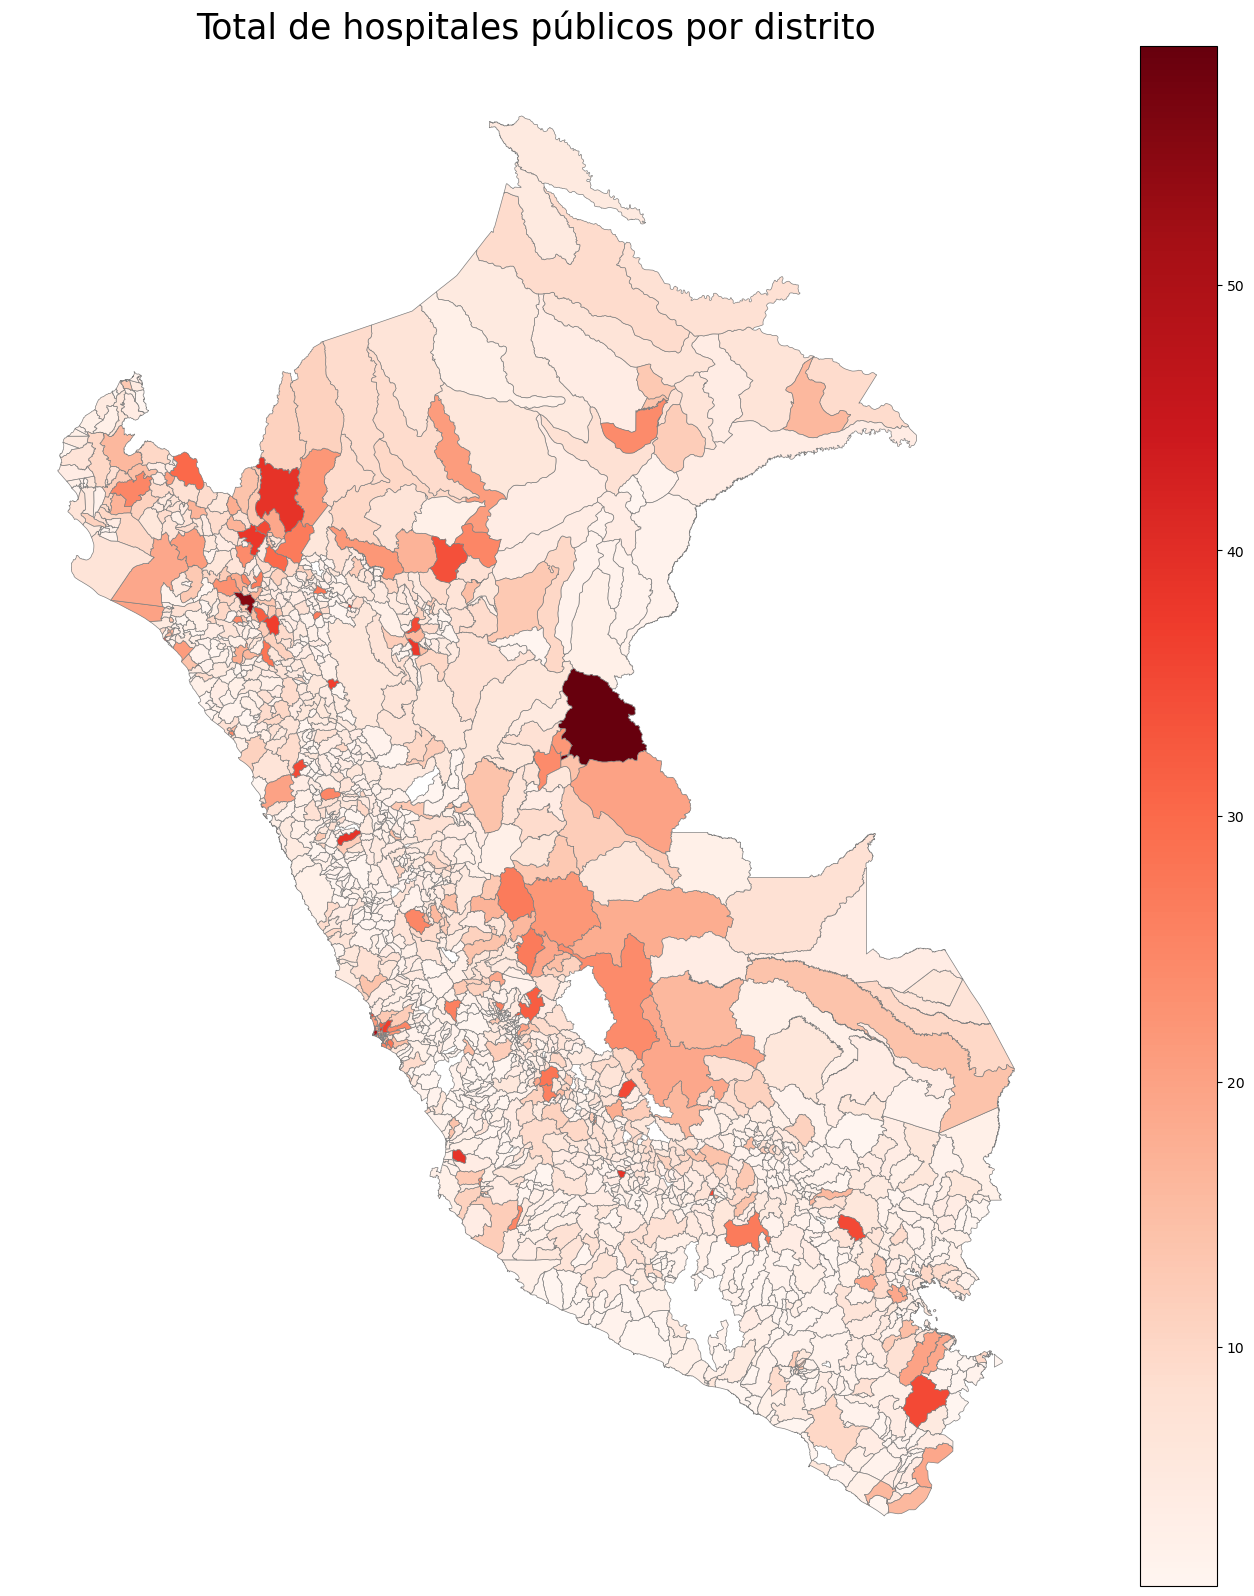

In [37]:
import matplotlib.pyplot as plt

# Graficar el mapa por cantidad de hospitales
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

datasetTHP.plot(
    column='Total_Hospitales',   # columna con los valores a representar
    cmap='Reds',                 # paleta de colores (puedes probar 'Blues', 'Greens', 'OrRd', etc.)
    linewidth=0.5,               # grosor de bordes
    edgecolor='gray',            # color de borde
    legend=True,                 # agrega leyenda de colores
    ax=ax
)

ax.set_title("Total de hospitales públicos por distrito", fontsize=25)
ax.axis('off')  # oculta los ejes
plt.show()


# Mapa 2: Resalta los distritos sin hospitales.

In [43]:
dataset["SHospitales"] = dataset["Clasificación"].isna()
dataset

,UBIGEO,geometry,Institución,Nombre del establecimiento,Clasificación,Departamento,Provincia,Distrito,Estado,NORTE,ESTE,SHospitales
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CODO DEL POZUZO,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.463665,-9.669402,False
1,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,HUAMPOMAYO,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.591200,-9.969250,False
2,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CHORROPAMPA,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.394620,-9.850610,False
3,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",GOBIERNO REGIONAL,PRINCIPE DE PAZ,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,TOURNAVISTA,ACTIVADO,-74.683542,-8.995790,False
4,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",GOBIERNO REGIONAL,TOURNAVISTA,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,TOURNAVISTA,ACTIVADO,-74.702805,-8.934338,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7950,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,PEÑICO,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.437500,-10.931177,False
7951,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",ESSALUD,CENTRO DE ATENCION PRIMARIA I HUMAYA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.409616,-11.098534,False
7952,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,VILCAHUAURA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.474190,-11.072751,False
7953,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,HUMAYA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.409943,-11.099675,False


In [ ]:
# Marcamos registros que no tienen distrito
dataset_hosp["Sin_Hospital"] = dataset_hosp["Clasificación"].isna()

# Creamos objeto con solo esos
a = dataset_hosp[dataset_hosp["Sin_Hospital"]].copy()

a

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

#Fondo del mapa todo gris
distritos.plot(
    color="lightgrey",
    linewidth=0.2,
    edgecolor="white",
    ax=ax
)

# mi objeto "a" en rojo
a.plot(
    color="red",
    linewidth=0.2,
    edgecolor="black",
    ax=ax,
    label="Sin hospitales"
)

# Título y leyenda
ax.set_title(f"Distritos sin hospitales públicos activos ({len(a)})", fontsize=14)
ax.set_axis_off()
ax.legend(title="Rojo: sin hospital registrado")

# Fuente
fig.text(
    0.5, -0.02,
    "Source: Ministry of Health (MINSA) - Peru",
    ha="center", fontsize=10, color="gray"
)

plt.show()

# Mapa 3: Los 10 distritos con el mayor número de hospitales (escala de color distinta).

In [76]:
top10_distritos = (
    datasetTHP[["Distrito", "Total_Hospitales","geometry"]]
    .drop_duplicates()                  # 1 fila por distrito
    .sort_values("Total_Hospitales", ascending=False)  #  Ordena los distritos de mayor a menor cantidad de hospitales
    .head(10)   # 🔹 Devuelve solo los 10 primeros
)

top10_distritos


,Distrito,Total_Hospitales,geometry
914,CALLERIA,59,"POLYGON ((-74.47145 -7.27617, -74.47052 -7.277..."
2140,CUTERVO,55,"POLYGON ((-78.98739 -6.26824, -78.98665 -6.268..."
845,CALLAO,51,"POLYGON ((-77.11219 -11.97352, -77.11203 -11.9..."
3045,INDEPENDENCIA,39,"POLYGON ((-73.8941 -13.83084, -73.89384 -13.83..."
3026,INDEPENDENCIA,39,"POLYGON ((-77.36995 -9.36978, -77.3698 -9.3705..."
2967,IMAZA,39,"POLYGON ((-78.61909 -4.51001, -78.61802 -4.510..."
3020,INDEPENDENCIA,39,"POLYGON ((-76.00477 -13.56126, -76.00346 -13.5..."
3046,INDEPENDENCIA,39,"POLYGON ((-77.02858 -11.96462, -77.02794 -11.9..."
672,BELLAVISTA,38,"POLYGON ((-80.66808 -4.89526, -80.66815 -4.897..."
666,BELLAVISTA,38,"POLYGON ((-76.65261 -6.87826, -76.65211 -6.879..."


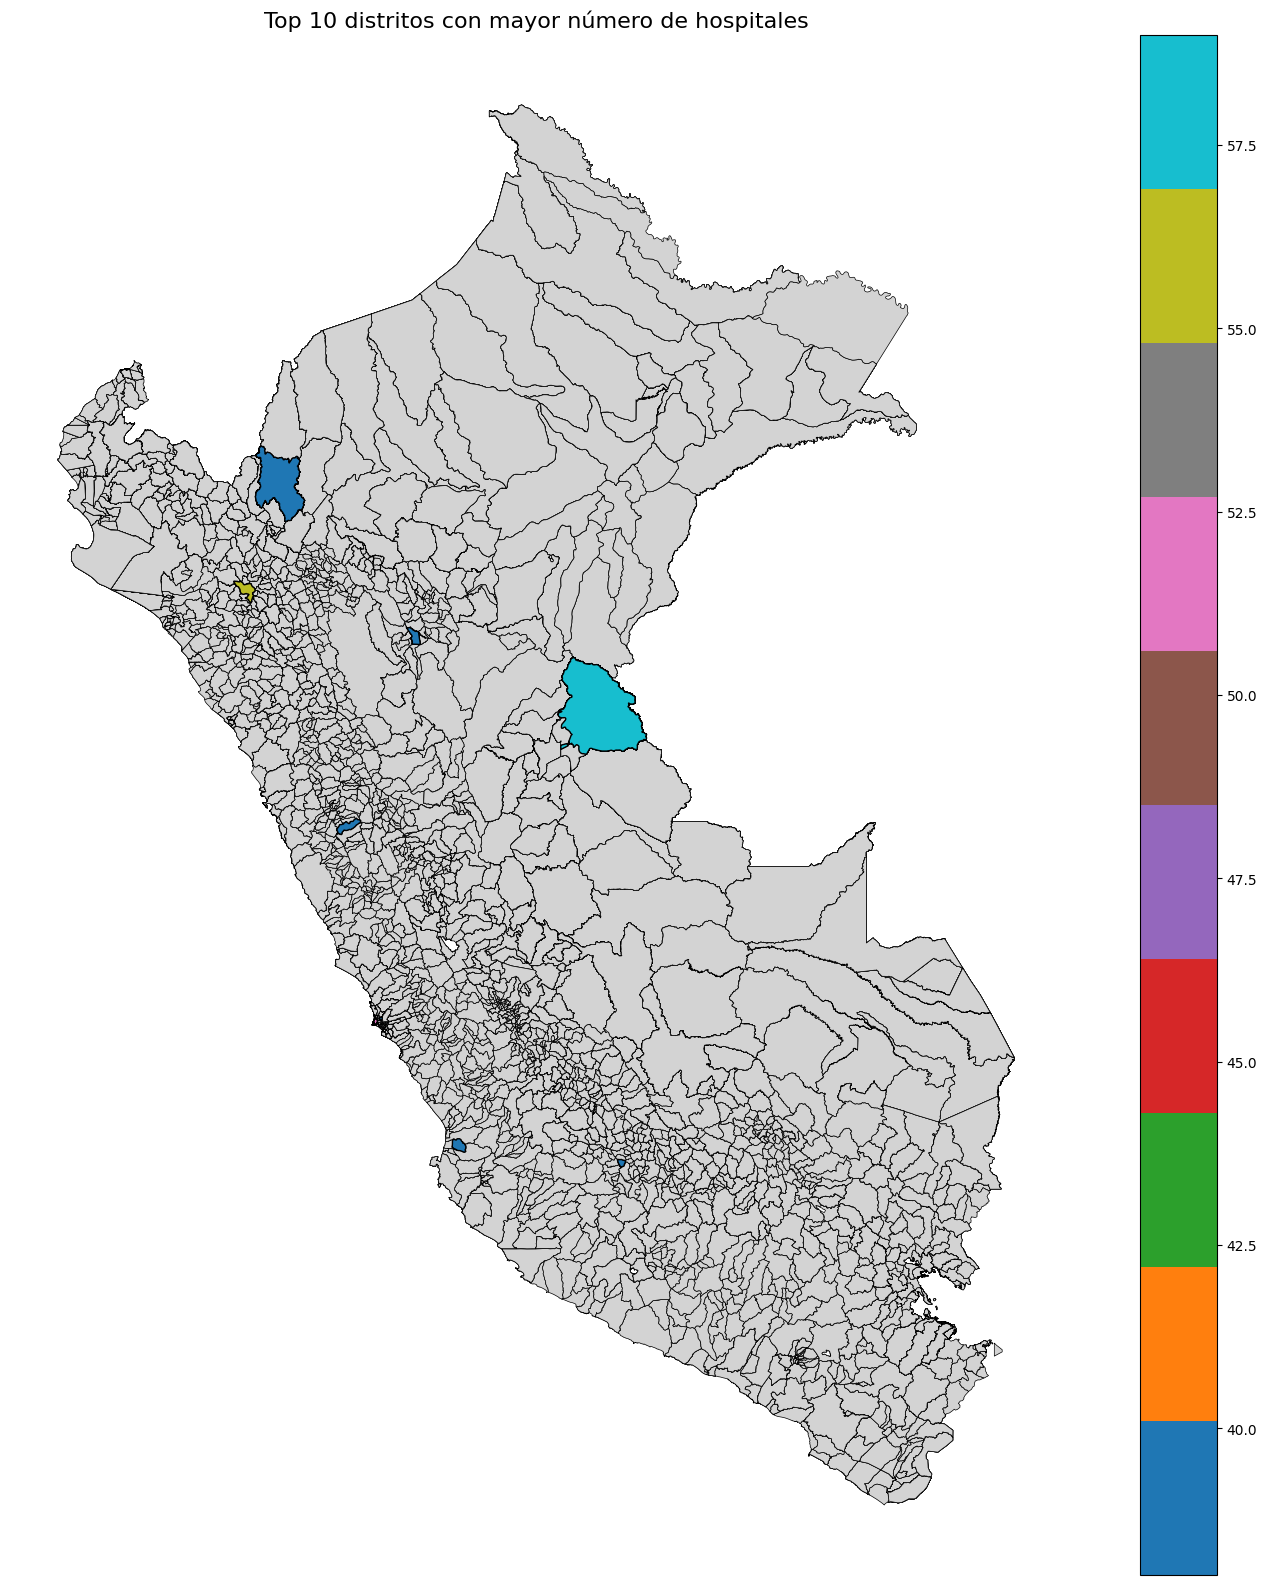

In [39]:
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Todo el dataset (base del mapa)
dataset.plot(
    ax=ax,
    color="lightgrey",      # color neutro para todos los distritos
    edgecolor="black",
    linewidth=0.5
)

# 2. Solo los top 10 distritos, encima
top10_distritos.plot(
    ax=ax,
    column="Total_Hospitales",   # colorear según cantidad
    cmap="tab10",                 # escala distinta (rojos)
    edgecolor="black",
    linewidth=1,
    legend=True
)

ax.set_title("Top 10 distritos con mayor número de hospitales", fontsize=16)
ax.set_axis_off()
plt.show()


Tarea 2: Análisis a nivel de departamento
- Agregue a nivel de departamento.
- Calcule el número total de hospitales operativos en cada departamento.
Identifique:
- El departamento con el mayor número de hospitales.
- El departamento con el menor número de hospitales.
Presente los resultados con:
- Una tabla resumen (ordenada de mayor a menor).
- Un gráfico de barras (matplotlib o seaborn).
- Un mapa coroplético a nivel de departamento (GeoPandas).

In [77]:
# Agrego a nivel de Departamento
departamentos = dataset.dissolve(by="Departamento").reset_index()
departamentos


,Departamento,geometry,UBIGEO,Institución,Nombre del establecimiento,Clasificación,Provincia,Distrito,Estado,NORTE,ESTE
0,AMAZONAS,"POLYGON ((-78.52725 -6.07256, -78.52912 -6.071...",10103,GOBIERNO REGIONAL,GOLLON,PUESTOS DE SALUD O POSTAS DE SALUD,CHACHAPOYAS,BALSAS,ACTIVADO,-77.941258,-6.733972
1,ANCASH,"POLYGON ((-78.19689 -9.99377, -78.19721 -9.993...",21805,GOBIERNO REGIONAL,CENTRO DE SALUD MORO,CENTROS DE SALUD O CENTROS MEDICOS,SANTA,MORO,ACTIVADO,-78.184656,-9.139803
2,APURIMAC,"POLYGON ((-73.61631 -14.0671, -73.61687 -14.06...",30607,GOBIERNO REGIONAL,TANCAYLLO,PUESTOS DE SALUD O POSTAS DE SALUD,CHINCHEROS,URANMARCA,ACTIVADO,-73.691135,-13.634594
3,AREQUIPA,"POLYGON ((-71.42635 -16.74309, -71.42642 -16.7...",40706,GOBIERNO REGIONAL,CENTRO DE SALUD LA PUNTA,CENTROS DE SALUD O CENTROS MEDICOS,ISLAY,PUNTA DE BOMBON,ACTIVADO,-71.794379,-17.172015
4,AYACUCHO,"POLYGON ((-74.50284 -15.16064, -74.5036 -15.16...",50404,GOBIERNO REGIONAL,ALLCOHUILLCA,PUESTOS DE SALUD O POSTAS DE SALUD,HUANTA,IGUAIN,ACTIVADO,-74.246628,-13.012062
5,CAJAMARCA,"POLYGON ((-79.08528 -7.46218, -79.08646 -7.461...",60505,GOBIERNO REGIONAL,SANTA ANA,PUESTOS DE SALUD O POSTAS DE SALUD,CONTUMAZA,SAN BENITO,ACTIVADO,-78.875322,-7.449424
6,CALLAO,"POLYGON ((-77.10934 -12.07632, -77.10998 -12.0...",70104,PRIVADO,POLICLINICO ESPECIALIZADO EN NEUROLOGIA S.A.C,CENTROS MEDICOS ESPECIALIZADOS,CALLAO,LA PERLA,ACTIVADO,-78.942340,-6.272000
7,CUSCO,"POLYGON ((-73.02202 -13.42405, -73.02381 -13.4...",80805,GOBIERNO REGIONAL,PALLPATA,PUESTOS DE SALUD O POSTAS DE SALUD,ESPINAR,PALLPATA,ACTIVADO,-71.210855,-14.892844
8,HUANCAVELICA,"POLYGON ((-75.11462 -14.03672, -75.1177 -14.03...",90613,GOBIERNO REGIONAL,SAN MIGUEL DE CURIS,PUESTOS DE SALUD O POSTAS DE SALUD,HUAYTARA,SANTIAGO DE CHOCORVOS,ACTIVADO,-75.184060,-13.876400
9,HUANUCO,"POLYGON ((-76.81024 -10.3928, -76.81152 -10.39...",100902,GOBIERNO REGIONAL,CODO DEL POZUZO,CENTROS DE SALUD O CENTROS MEDICOS,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.463665,-9.669402


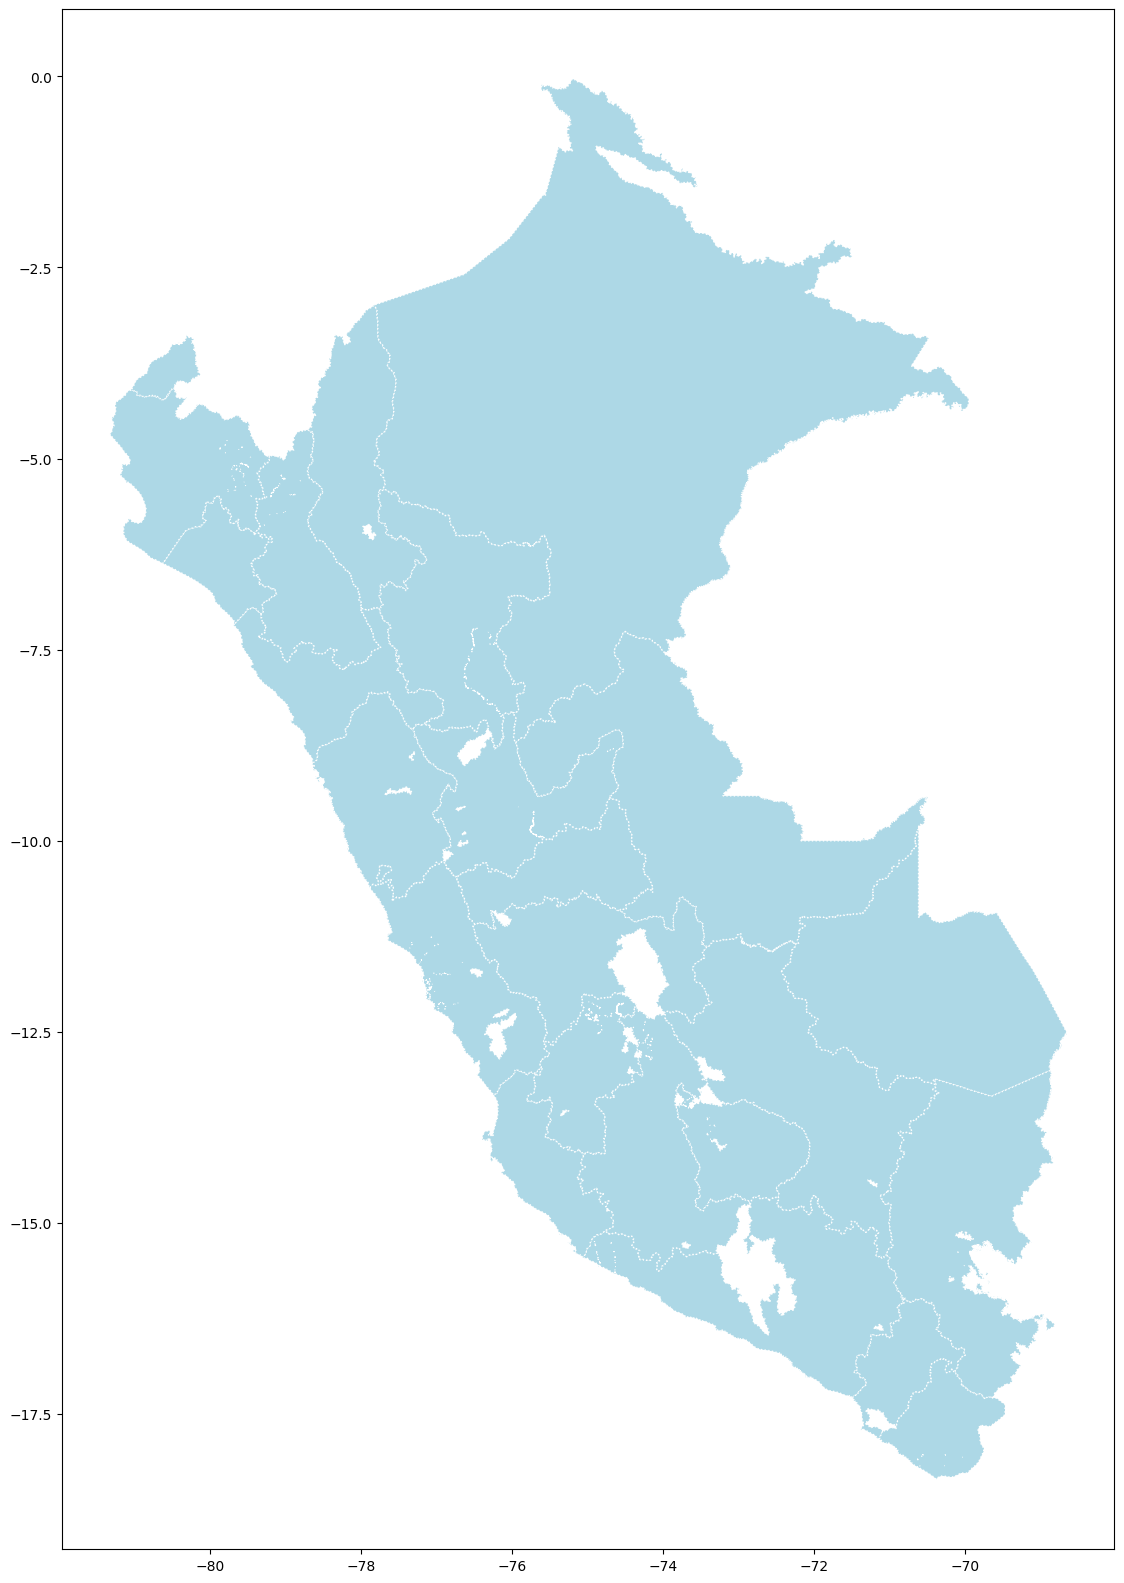

In [79]:
# Plot using geopandas
#figure and axis
fig, ax = plt.subplots(figsize=(20, 20))

departamentos.plot(  ax=ax, color='lightblue', linestyle='dotted',
            edgecolor='white' )
plt.show()



# Número total de hospitales operativos en cada departamento.
Identifique:
- El departamento con el mayor número de hospitales: Cajamarca
- El departamento con el menor número de hospitale:Tumbes

In [ ]:
# Tabla de conteo de hospitales por Departamento ordenado de mayor a menor en torno a Departamento (alfabético)
hospordepto = (
    dataset.groupby("Departamento")
    .size()
    .reset_index(name="NumerodeHospitales")
    .sort_values("Departamento", ascending=True)
)
hospordepto


# 2. Crear tabla de conteo de hospitales por Departamento
hosp_depto = (
    dataset.groupby("Departamento")
    .size()
    .reset_index(name="N_Hospitales")
    .sort_values("Departamento", ascending=True)
)
hosp_depto

,Departamento,NumerodeHospitales
0,AMAZONAS,417
1,ANCASH,416
2,APURIMAC,375
3,AREQUIPA,224
4,AYACUCHO,387
5,CAJAMARCA,845
6,CALLAO,97
7,CUSCO,339
8,HUANCAVELICA,325
9,HUANUCO,261


In [86]:
# Tabla de conteo de hospitales por Departamento ordenado de mayor a menor
hospordepto = (
    dataset.groupby("Departamento")
    .size()
    .reset_index(name="NumerodeHospitales")
    .sort_values("NumerodeHospitales", ascending=True)
)
hospordepto

,Departamento,NumerodeHospitales
23,TUMBES,54
17,MOQUEGUA,56
16,MADRE DE DIOS,66
22,TACNA,79
6,CALLAO,97
10,ICA,146
13,LAMBAYEQUE,181
3,AREQUIPA,224
24,UCAYALI,234
18,PASCO,258


In [ ]:
type(hospordepto)

pandas.core.frame.DataFrame

### Presente los resultados con:
##### Un gráfico de barras (matplotlib o seaborn).

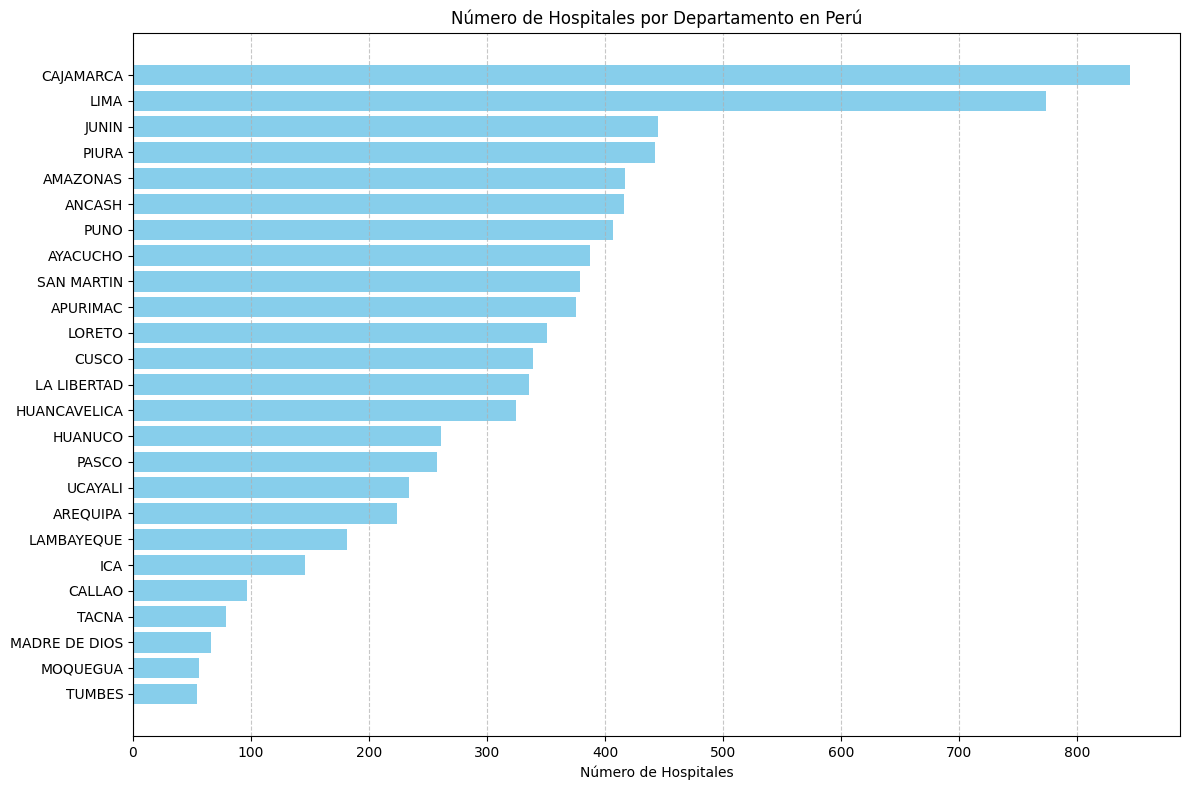

In [92]:
import matplotlib.pyplot as plt

# Ordenar por número de hospitales
hospordepto_sorted = hospordepto.sort_values(by="NumerodeHospitales", ascending=True)

# Crear el gráfico
plt.figure(figsize=(12, 8))
plt.barh(hospordepto_sorted["Departamento"], hospordepto_sorted["NumerodeHospitales"], color='skyblue')
plt.xlabel("Número de Hospitales")
plt.title("Número de Hospitales por Departamento en Perú")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Un mapa coroplético a nivel de departamento (GeoPandas).

In [96]:

# 3. Merge de geometría con conteo
dep_hosp = dataset.merge(hospordepto, on="Departamento", how="left")
dep_hosp["NumerodeHospitales"] = dep_hosp["NumerodeHospitales"].fillna(0)

In [97]:
dep_hosp

,UBIGEO,geometry,Institución,Nombre del establecimiento,Clasificación,Departamento,Provincia,Distrito,Estado,NORTE,ESTE,NumerodeHospitales
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CODO DEL POZUZO,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.463665,-9.669402,261.0
1,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,HUAMPOMAYO,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.591200,-9.969250,261.0
2,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",GOBIERNO REGIONAL,CHORROPAMPA,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,CODO DEL POZUZO,ACTIVADO,-75.394620,-9.850610,261.0
3,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",GOBIERNO REGIONAL,PRINCIPE DE PAZ,PUESTOS DE SALUD O POSTAS DE SALUD,HUANUCO,PUERTO INCA,TOURNAVISTA,ACTIVADO,-74.683542,-8.995790,261.0
4,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",GOBIERNO REGIONAL,TOURNAVISTA,CENTROS DE SALUD O CENTROS MEDICOS,HUANUCO,PUERTO INCA,TOURNAVISTA,ACTIVADO,-74.702805,-8.934338,261.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7950,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,PEÑICO,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.437500,-10.931177,774.0
7951,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",ESSALUD,CENTRO DE ATENCION PRIMARIA I HUMAYA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.409616,-11.098534,774.0
7952,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,VILCAHUAURA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.474190,-11.072751,774.0
7953,150806,"POLYGON ((-77.3763 -10.89734, -77.37604 -10.89...",GOBIERNO REGIONAL,HUMAYA,PUESTOS DE SALUD O POSTAS DE SALUD,LIMA,HUAURA,HUAURA,ACTIVADO,-77.409943,-11.099675,774.0


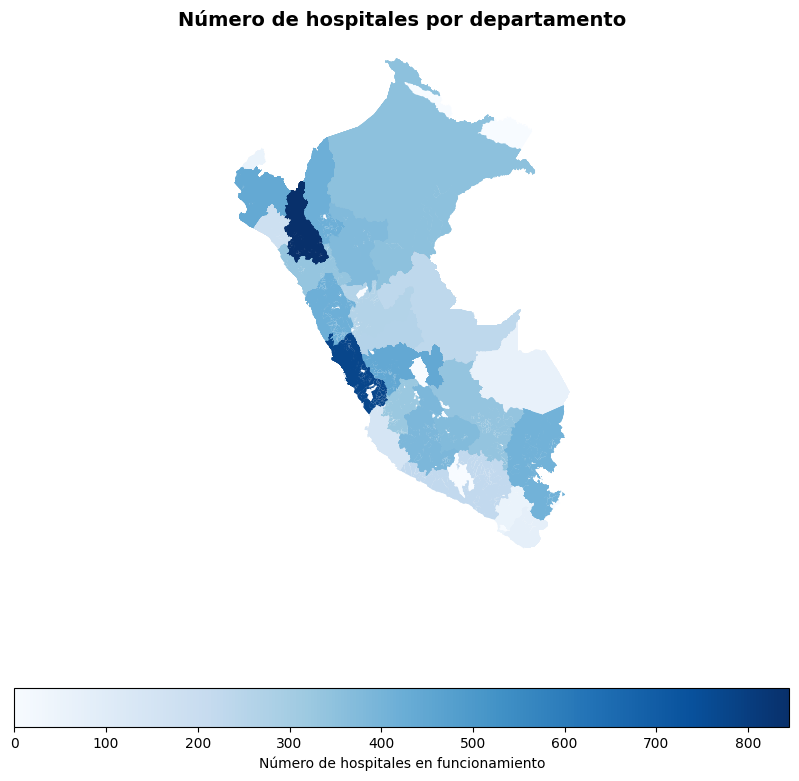

In [102]:
# 4. Graficar mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
dep_hosp.plot(
    column="NumerodeHospitales",
    cmap="Blues",
    linewidth=0.5,
    edgecolor="none",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": "Número de hospitales en funcionamiento",
        "orientation": "horizontal"
    }
)
ax.set_title("Número de hospitales por departamento", fontsize=14, fontweight="bold")
ax.set_axis_off()
plt.show()